To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [6]:
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../build/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel

# Spherical Invariants: body order = 3

In [5]:
# Load the small molecules 
frames = read('../reference_data/inputs/small_molecules-1000.xyz',':100')

In [9]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              )
soap = SphericalInvariants(**hypers)
zeta=1
kernel1 = Kernel(soap,name='Cosine', zeta=zeta, target_type='Structure', kernel_type='Full')

In [10]:
representation = soap.transform(frames)
X = representation.get_features(soap)

In [11]:
%%time 
kk = np.power(np.dot(X, X.T), zeta)

CPU times: user 315 ms, sys: 202 ms, total: 517 ms
Wall time: 83.3 ms


In [12]:
%time kernel1(representation)

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


array([[0.87814618, 0.87572849, 0.63829521, ..., 0.84570755, 0.78231911,
        0.8865185 ],
       [0.87572849, 0.91467176, 0.64065155, ..., 0.88239468, 0.7872502 ,
        0.90312866],
       [0.63829521, 0.64065155, 0.84461403, ..., 0.68464459, 0.65093867,
        0.62834446],
       ...,
       [0.84570755, 0.88239468, 0.68464459, ..., 0.89584525, 0.8080138 ,
        0.86432172],
       [0.78231911, 0.7872502 , 0.65093867, ..., 0.8080138 , 0.76603393,
        0.78026716],
       [0.8865185 , 0.90312866, 0.62834446, ..., 0.86432172, 0.78026716,
        0.92726278]])

In [13]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=4, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              expansion_by_species_method='user defined',
              normalize=True,
              global_species=[1, 6, 7, 8],
              )
soap = SphericalInvariants(**hypers)
zeta=2
kernel1 = Kernel(soap, zeta=zeta, target_type='Atom')
representation = soap.transform(frames)

In [14]:
%time kernel1(representation)

CPU times: user 335 ms, sys: 3.41 ms, total: 339 ms
Wall time: 337 ms


array([[1.        , 0.00472567, 0.11009869, ..., 0.04595198, 0.04978086,
        0.03560331],
       [0.00472567, 1.        , 0.11667004, ..., 0.05571336, 0.06607319,
        0.04509975],
       [0.11009869, 0.11667004, 1.        , ..., 0.05723611, 0.06780385,
        0.06020636],
       ...,
       [0.04595198, 0.05571336, 0.05723611, ..., 1.        , 0.85119125,
        0.84384698],
       [0.04978086, 0.06607319, 0.06780385, ..., 0.85119125, 1.        ,
        0.84252262],
       [0.03560331, 0.04509975, 0.06020636, ..., 0.84384698, 0.84252262,
        1.        ]])

In [15]:
aa = kernel1(representation)
bb = kernel1(representation, representation)
np.allclose(aa, bb)

True

# Make a map of the dataset

## utils

In [7]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [8]:
# Load the small molecules 
frames = read('../reference_data/inputs/small_molecules-1000.xyz',':600')

In [9]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap,name='Cosine', zeta=2, target_type='Structure', kernel_type='Full')

In [10]:
managers = soap.transform(frames)

Kmat = kernel(managers)

In [11]:
from sklearn.decomposition import KernelPCA

In [12]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(Kmat)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='precomputed',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)

In [13]:
X = kpca.transform(Kmat)

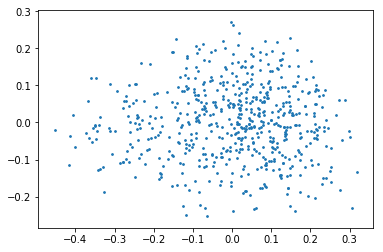

In [14]:
plt.scatter(X[:,0],X[:,1],s=3)

## make an interactive map

In [15]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [16]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

NGLWidget(count=600)

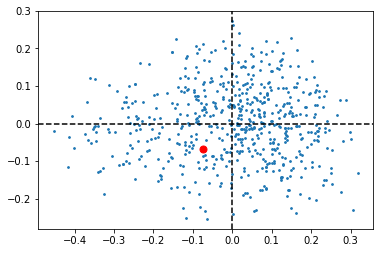

In [17]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg